In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F

import numpy as np

import gym
import d4rl

from rlkit.torch.networks import Mlp
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 10)


No module named 'flow'
(65544) b'X11: The DISPLAY environment variable is missing'
No module named 'carla'


In [2]:
def get_bonus(obs, actions, network):
    data = torch.cat((obs, actions), dim=1)
    # print('size of data:{}'.format(data.size()))
    
    with torch.no_grad():
        bonus = network(data)
    print('size of bonus:{}'.format(bonus.size()))
    
    return bonus

In [3]:
def get_bonus_random_actions(obs, actions, network):
    action_shape = actions.shape[0]
    obs_shape = obs.shape[0]
    num_repeat = int (action_shape / obs_shape)
    obs_temp = obs.unsqueeze(1).repeat(1, num_repeat, 1).view(obs.shape[0] * num_repeat, obs.shape[1])
    # feed to the bonus networks
    data = torch.cat((obs_temp, actions), dim=1)
    with torch.no_grad():
        bonus = network(data)
    # reshape
    bonus = bonus.view(obs.shape[0], num_repeat, 1)
    print('size of bonus:{}'.format(bonus.size()))

    return bonus

In [4]:
def load_models(model_name):
    
    M = 64
    network = Mlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=[M, M],
        output_activation=F.sigmoid,
    )

    
    path = '../models/{}'.format(model_name)
    checkpoint = torch.load(path, map_location='cpu')
    network.load_state_dict(checkpoint['network_state_dict'])

    print('Loading model: {}'.format(path))
    
    return network

In [5]:
num_random = 10

# walker2d

In [16]:
env_name = 'walker2d-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)

dataset = env.get_dataset()
obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']
min_reward = min(rewards)
max_reward = max(rewards)

print('min_reward:{}, max_reward:{}, range: {}'.format(min_reward, max_reward, max_reward - min_reward))

17
6
min_reward:-5.741327285766602, max_reward:8.771693229675293, range: 14.513020515441895


In [17]:
model_name = 'Nov-30-2020_1124_walker2d-medium-v0.pt'
model_name = 'Nov-30-2020_1133_walker2d-medium-v0.pt'
model_name = 'Nov-30-2020_1147_walker2d-medium-v0.pt'
network_1 = load_models(model_name)
bonus_1 = get_bonus(obs, actions, network_1,).detach().cpu().numpy()

Loading model: ../models/Nov-30-2020_1147_walker2d-medium-v0.pt
size of bonus:torch.Size([1000000, 1])


In [18]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)
bonus_random_1 = get_bonus_random_actions(obs, random_actions, network_1).detach().cpu().numpy()
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)


size of bonus:torch.Size([1000000, 10, 1])


In [19]:
ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]

bonus_shuffled_1 = get_bonus(obs, shuffled_actions, network_1).detach().cpu().numpy()

size of bonus:torch.Size([1000000, 1])


In [ ]:
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)
reward_mean = np.mean(rewards)
delta_bonus_1 = abs(bonus_random_1_mean - bonus_1).squeeze(1)

delta_bonus_1_mean = np.mean(delta_bonus_1)
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_1_mean))
rho1_mean = reward_mean / delta_bonus_1_mean
print('rho1:{0:0.2g}'.format(rho1_mean))


rho2_mean = np.mean(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
print('rho2:{0:.2g}'.format(rho2_mean))

In [ ]:
bonus_random_1_median = np.mean(bonus_random_1, axis=1)
reward_median = np.median(rewards)
delta_bonus_1 = abs(bonus_random_1_median - bonus_1).squeeze(1)

delta_bonus_1_median = np.median(delta_bonus_1)
print('median reward:{}, delta_bonus:{}'.format(reward_median,delta_bonus_1_median))
rho1_median = reward_median / delta_bonus_1_median
print('rho1:{0:0.2g}'.format(rho1_median))


rho2_median = np.median(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
print('rho2:{0:.2g}'.format(rho2_median))

Text(0.5, 0.98, 'normalized bonus with rho_1 and mean statistics')

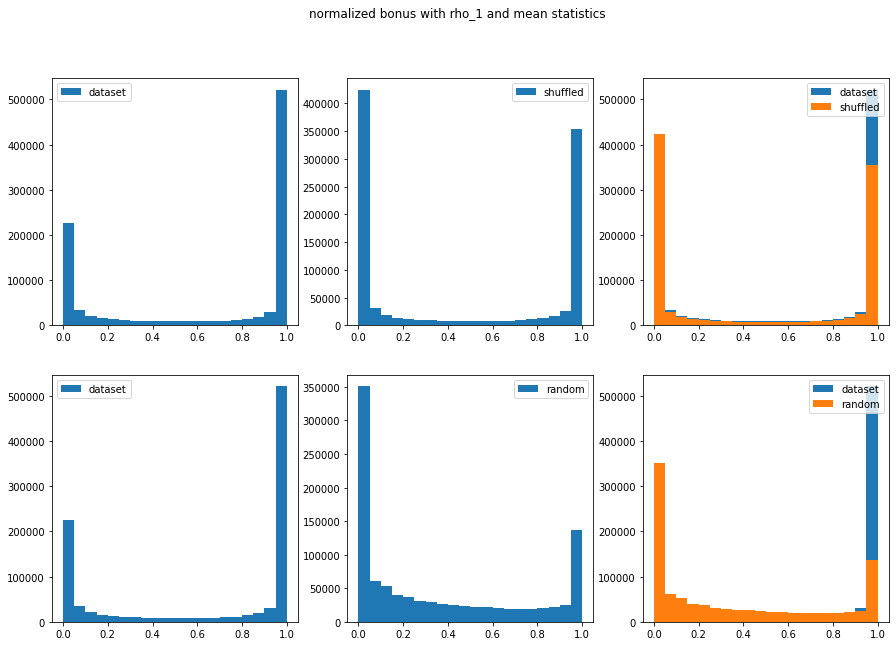

In [21]:
num_bins = 20
matplotlib.rcParams['figure.figsize'] = (15, 10)
fig=plt.figure()
plt.subplot(2, 3, 1)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.hist(bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.hist(bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

plt.suptitle('normalized bonus with rho_1 and mean statistics')

# Halfcheetah

In [6]:
env_name = 'halfcheetah-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)

dataset = env.get_dataset()
obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']
min_reward = min(rewards)
max_reward = max(rewards)

print('min_reward:{}, max_reward:{}, range: {}'.format(min_reward, max_reward, max_reward - min_reward))

/usr/local/google/home/shideh/virtual_env/ML/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


17
6
min_reward:-2.8285481929779053, max_reward:8.10350513458252, range: 10.932053565979004


In [27]:
model_name = 'Nov-30-2020_1217_halfcheetah-medium-v0.pt'
model_name = 'Nov-30-2020_1226_halfcheetah-medium-v0.pt'
network_1 = load_models(model_name)
bonus_1 = get_bonus(obs, actions, network_1,).detach().cpu().numpy()

Loading model: ../models/Nov-30-2020_1226_halfcheetah-medium-v0.pt
size of bonus:torch.Size([1000000, 1])


In [28]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)
bonus_random_1 = get_bonus_random_actions(obs, random_actions, network_1).detach().cpu().numpy()
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)


size of bonus:torch.Size([1000000, 10, 1])


In [29]:
bonus_1[:2]

array([[1.7843953e-06],
       [1.2184271e-06]], dtype=float32)

In [30]:
ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]

bonus_shuffled_1 = get_bonus(obs, shuffled_actions, network_1).detach().cpu().numpy()

size of bonus:torch.Size([1000000, 1])


Text(0.5, 0.98, 'normalized bonus with rho_1 and mean statistics')

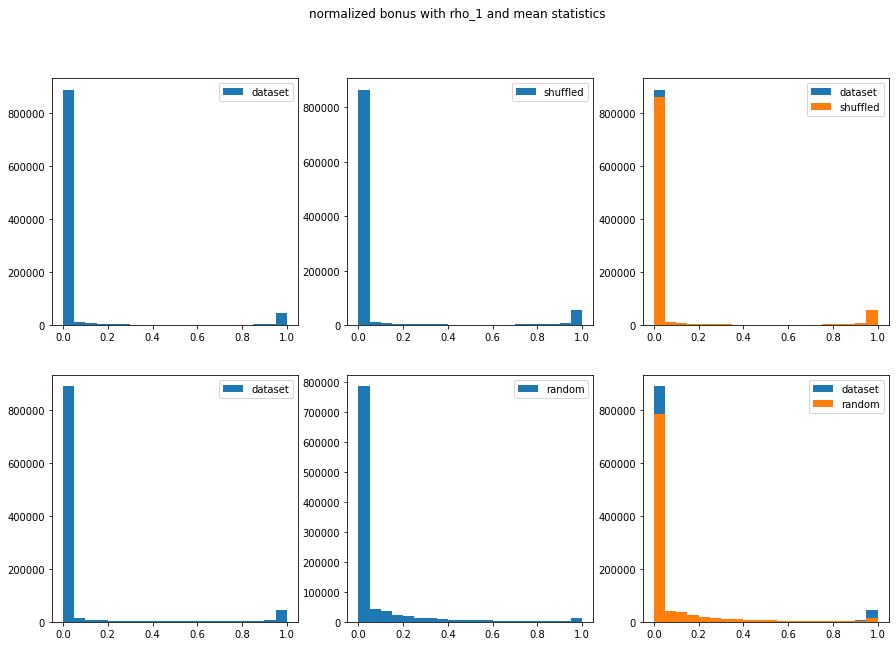

In [31]:
num_bins = 20
matplotlib.rcParams['figure.figsize'] = (15, 10)
fig=plt.figure()
plt.subplot(2, 3, 1)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.hist(bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(bonus_1, bins = num_bins, label='dataset')
plt.hist(bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

plt.suptitle('normalized bonus with rho_1 and mean statistics')